# Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:  
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.  

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.  
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**   
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.  
    - 0 - Коричневый карлик
    - 1 - Красный карлик
    - 2 - Белый карлик
    - 3 - Звёзды главной последовательности
    - 4 - Сверхгигант
    - 5 - Гипергигант  

- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.  

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

💡 Справочная информация:  
Светимость Солнца (англ. Average Luminosity of Sun)  
 $L_0 = 3.828 \cdot 10^{26}\,Вт$   

Радиус Солнца (англ. Average Radius of Sun)   
 $R_0 = 6.9551\cdot 10^8\,м$  

## Импорт библиотек и подготовка окружения

In [81]:
!pip install skorch
import pandas as pd
import numpy as np
import random
import re
import math
import torch as t
import torch.nn as nn
from skorch import NeuralNetRegressor

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

In [2]:
# Зафиксируем random seed
random.seed(0)
np.random.seed(0)
t.manual_seed(0)
t.use_deterministic_algorithms(True)

## Загрузка данных

In [3]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)

# Приведем названия столбцов к более удобному виду.
data.columns = [re.sub("\([a-zA-Z/]*?\)", "", col).strip() for col in data.columns]
data.columns =[re.sub("\s", "_", col) for col in data.columns]

data.head()

Temperature  Luminosity  Radius  Absolute_magnitude  Star_type Star_color
0         3068    0.002400  0.1700               16.12          0        Red
1         3042    0.000500  0.1542               16.60          0        Red
2         2600    0.000300  0.1020               18.70          0        Red
3         2800    0.000200  0.1600               16.65          0        Red
4         1939    0.000138  0.1030               20.06          0        Red

In [4]:
# Посмотрим информацию о данных.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         240 non-null    int64  
 1   Luminosity          240 non-null    float64
 2   Radius              240 non-null    float64
 3   Absolute_magnitude  240 non-null    float64
 4   Star_type           240 non-null    int64  
 5   Star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
# Посмотрим на описание данных.
data.describe()

Temperature     Luminosity       Radius  Absolute_magnitude  \
count    240.000000     240.000000   240.000000          240.000000   
mean   10497.462500  107188.361635   237.157781            4.382396   
std     9552.425037  179432.244940   517.155763           10.532512   
min     1939.000000       0.000080     0.008400          -11.920000   
25%     3344.250000       0.000865     0.102750           -6.232500   
50%     5776.000000       0.070500     0.762500            8.313000   
75%    15055.500000  198050.000000    42.750000           13.697500   
max    40000.000000  849420.000000  1948.500000           20.060000   

        Star_type  
count  240.000000  
mean     2.500000  
std      1.711394  
min      0.000000  
25%      1.000000  
50%      2.500000  
75%      4.000000  
max      5.000000

У данных разный масштаб. Необходимо масштабирование.

Посмотрим на уникальные значения столбца `Star_color`:

In [6]:
data.Star_color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Присутствуют неявные дубликаты.  
Посмотрим на присутствие явных дубликатов.

In [7]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют. (Можно проверить также после предобработки)

**Резюме**

- Всего есть 5 признаков: 3 - числовые ('Luminosity', 'Radius', 'Absolute_magnitude'), 2 - категориальные ('Star_type', 'Star_color'). И один целевой признак, выраженный вещественным числом.
- Пропуски отсутствуют
- У данных разный масштаб. Требуется масштабирование.
- В столбце `Star_color` присутствуют неявные дубликаты, требуется предобработка.

## Предобработка и анализ данных

Посмотрим на взаимное распределение признаков, выраженных вещественными числами. Помним, что один из низ - `Star_type` - категориальный.

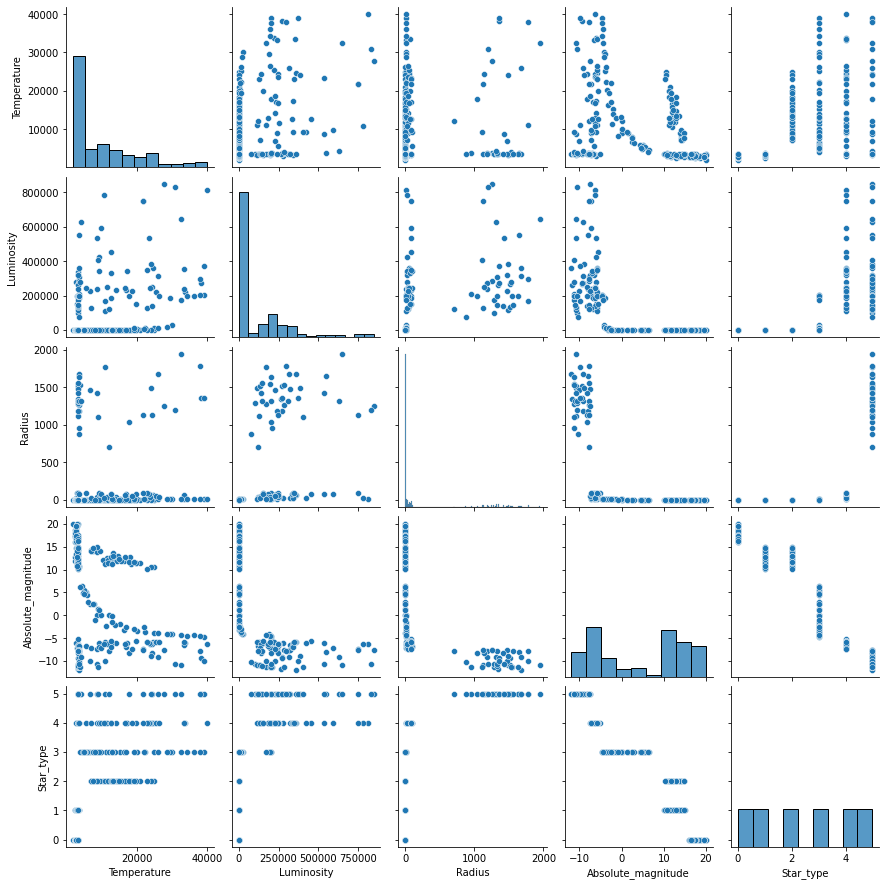

In [8]:
sns.pairplot(data=data);

На графике можно наблюдать, что:
- Абсолютная звездная величина (`Absolute_magnitude`) возможно имеет корреляцию с типом звезды (`Star_type`)
- Абсолютная звездная величина (`Absolute_magnitude`) возможно имеет корреляцию с относительной светимостью (`Luminosity`)
- Абсолютная звездная величина (`Absolute_magnitude`) возможно имеет корреляцию с температурой (`Temperature`)

Из [справки](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0_%D0%93%D0%B5%D1%80%D1%86%D1%88%D0%BF%D1%80%D1%83%D0%BD%D0%B3%D0%B0_%E2%80%94_%D0%A0%D0%B0%D1%81%D1%81%D0%B5%D0%BB%D0%B0) в вкикпедии становится понятно, что тип звезды классифицируется по большому счету в зависимости от ее абсолютной звездной величины. Второй признак - это спектральный класс. Он описывает вид спектра, зависящий в первую очередь от температуры.  
Таким образом, возможно, нам стоит убрать признак `Star_type` из данных. В лучшем случае он будет избыточным, в худшем - приведет к утечке данных.  
Ниже приведена Диаграмма Герцшпрунга — Рассела ([источник](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0_%D0%93%D0%B5%D1%80%D1%86%D1%88%D0%BF%D1%80%D1%83%D0%BD%D0%B3%D0%B0_%E2%80%94_%D0%A0%D0%B0%D1%81%D1%81%D0%B5%D0%BB%D0%B0))  

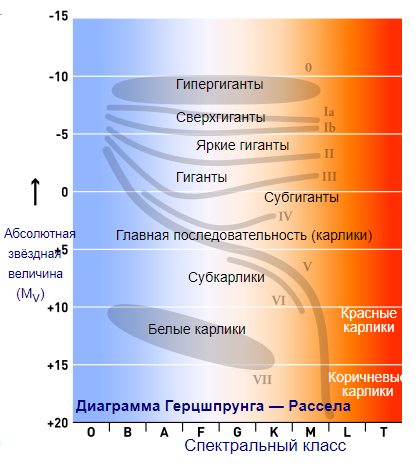

Посмотрим на корреляцию в данных:

In [9]:
data.corr()

Temperature  Luminosity    Radius  Absolute_magnitude  \
Temperature            1.000000    0.393404  0.064216           -0.420261   
Luminosity             0.393404    1.000000  0.526516           -0.692619   
Radius                 0.064216    0.526516  1.000000           -0.608728   
Absolute_magnitude    -0.420261   -0.692619 -0.608728            1.000000   
Star_type              0.411129    0.676845  0.660975           -0.955276   

                    Star_type  
Temperature          0.411129  
Luminosity           0.676845  
Radius               0.660975  
Absolute_magnitude  -0.955276  
Star_type            1.000000

Из таблицы корреляции хорошо видно, что:  
- Температура (целевой показатель) имеет корреляцию с Абсолютной звездной величиной (-0.42) и относительной светимостью (0.39)
- Относительная светимость имеет сильную корреляцию с радиусом (-0.53)
- Радиус имеет сильную корреляцию с Абсолютной звездной величиной (-0.61)

P.S.
Данные по признаку Тип звезды не включены в резюме, так как этот признак будет исключен из данных.

Посмотрим на график размаха.

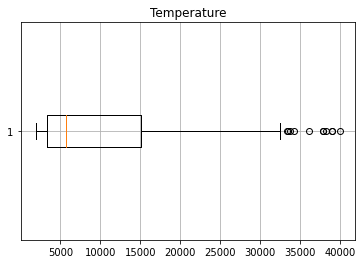

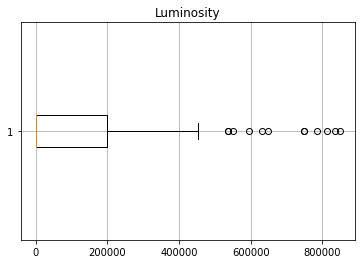

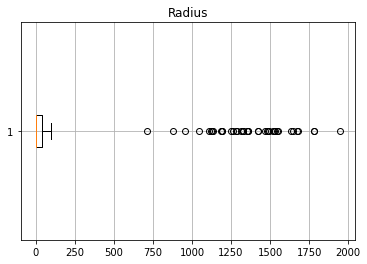

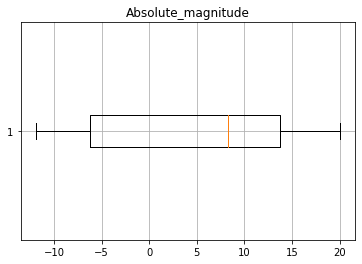

In [10]:
for col in data.drop(['Star_type', 'Star_color'], axis=1).columns:
    plt.boxplot(data[col], vert=False)
    plt.grid()
    plt.title(col)
    plt.show()

Посмотрим на категориальные признаки.

### Признак `Star_color`

In [11]:
data['Star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
yellowish               2
Orange                  2
Whitish                 2
Orange-Red              1
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Blue-White              1
Blue                    1
Blue white              1
Name: Star_color, dtype: int64

Предобработаем значения: избавимся от неявных дубликатов.

In [12]:
# Приведем к нижнему регистру и удалим пробелы слева и справа от значений
data['Star_color'] = data['Star_color'].str.lower().str.strip()
data['Star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

In [13]:
# Заменим пробелы на "-"
data['Star_color'] = data['Star_color'].apply(lambda color: re.sub('\s', "-", color))
data['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'white-yellow', 'yellowish', 'orange-red'], dtype=object)

In [14]:
# Заменим 'white-yellow' на 'yellow-white'
data['Star_color'] = data['Star_color'].mask(data['Star_color'] == 'white-yellow', 'yellow-white')
data['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'yellowish', 'orange-red'], dtype=object)

In [15]:
data['Star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
orange                  2
whitish                 2
pale-yellow-orange      1
orange-red              1
Name: Star_color, dtype: int64

Посмотрим на корреляцию с температурой.

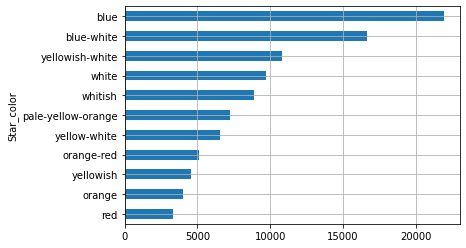

In [16]:
data.groupby('Star_color')['Temperature'].mean().sort_values().plot.barh(grid=True);

На графике видно, что при переходе от одного спектра цвета к другому температура меняется.  
Из физики можно также вспомнить, что цвет планеты действительно в определенной мере зависит от ее температуры. Поэтому, этот признак действительно может быть достаточно информативным.

Избавимся от единичных цветов. Для этого будем исходить из схожести названий и близости по температурам. Объединим `pale-yellow-orange` с `yellow-white`, а `orange-red` c `orange`. 

In [17]:
data['Star_color'] = data['Star_color'].mask(data['Star_color'] == 'pale-yellow-orange', 'yellow-white')
data['Star_color'] = data['Star_color'].mask(data['Star_color'] == 'orange-red', 'orange')
data['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white', 'yellow-white',
       'blue', 'whitish', 'orange', 'yellowish'], dtype=object)

**Резюме**  
На данном этапе мы провели краткий исследовательский анализ данных, в ходе которого было выявлено, что:    
- Температура (целевой показатель) имеет корреляцию с Абсолютной звездной величиной (-0.42), Относительной светимостью (0.39) и Цветом звезды
- Относительная светимость имеет сильную корреляцию с Радиусом (-0.53)
- Радиус имеет сильную корреляцию с Абсолютной звездной величиной (-0.61)

На основании анализа, было принято решение исключить признак `Star_type` из обучения, так как он может быть излишним и его наличие может привести к утечке данных.  
Также, была произведена предобработка данных, в ходе которой признак `Star_color` был очищен от неявных дубликатов и редко встречающихся значений.

## Подготовка данных к построению модели

In [18]:
# Сохраним признаки и таргет в переменные X и y соотвественно.
X = data[['Luminosity', 'Radius', 'Absolute_magnitude', 'Star_color']]
y = data['Temperature']

# Разделим данные на тренировочный и тестовый сет.
raw_train_X, raw_test_X, raw_train_y, raw_test_y = train_test_split(X, y, random_state=2, test_size=0.2)

# Инициализируем класс, который будет предобрабрабатывать данные
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['Luminosity', 'Radius', 'Absolute_magnitude']),
    ('one_hot_encode', OneHotEncoder(sparse=False, drop='first'), ['Star_color'])
  ]
)

# Инициализируем PCA
pca = PCA(n_components='mle', svd_solver='full', random_state=1)

In [19]:
# Создадим признаки, к которым был применен PCA
pca_train_X = pca.fit_transform(ct.fit_transform(raw_train_X))
pca_test_X = pca.transform(ct.transform(raw_test_X))

pca_train_X.shape, pca_test_X.shape

((192, 10), (48, 10))

In [20]:
# Создадим признаки, к которым не был применен PCA
tens_train_X = t.Tensor(ct.fit_transform(raw_train_X))
tens_test_X = t.Tensor(ct.transform(raw_test_X))
print('tens_train_X:', tens_train_X.shape, '|', 'tens_test_X:', tens_test_X.shape)

pca_tens_train_X = t.Tensor(pca_train_X)
pca_tens_test_X = t.Tensor(pca_test_X)
print('pca_tens_train_X:', pca_tens_train_X.shape, '|', 'pca_tens_test_X:', pca_tens_test_X.shape)

tens_train_y = t.Tensor(raw_train_y.values)
tens_test_y = t.Tensor(raw_test_y.values)
print('tens_train_y:', tens_train_y.shape, '|', 'tens_test_y:', tens_test_y.shape)

tens_train_X: torch.Size([192, 11]) | tens_test_X: torch.Size([48, 11])
pca_tens_train_X: torch.Size([192, 10]) | pca_tens_test_X: torch.Size([48, 10])
tens_train_y: torch.Size([192]) | tens_test_y: torch.Size([48])


Посмотрим как распределена температура в тренировочном и тестовом наборе данных.

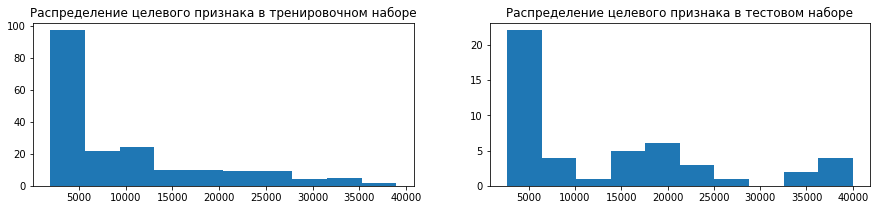

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].hist(tens_train_y.numpy());
ax[0].set_title("Распределение целевого признака в тренировочном наборе")

ax[1].hist(tens_test_y.numpy());
ax[1].set_title("Распределение целевого признака в тестовом наборе");

Распределение более менее одинаково.

**Резюме:**  
На данном этапе мы:
- Разделили выборку на тренировочную и тестовую
- Преобразовали категогриальные признаки методом one-hot encoding
- Отмасштабировали количественные признаки
- Создали еще один набор обучающих признаков, к которму применили метод PCA для уменьшения размерности.

## Построение базовой нейронной сети

In [21]:
# Зададим функцию, которая будет обучать нейронную сеть
def fit_net(net, train_X, train_y, test_X, test_y, num_epochs, show_res_every=1000, lr=1e-1, l1_reg=0, l2_reg=0, early_stop=4500):
    optimizer = t.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(train_X).flatten()
        train_loss = loss(preds, train_y)
        
        l1_lambda = l1_reg
        l1_norm = sum(p.abs().sum() for p in net.parameters())
        l2_lambda = l2_reg
        l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
        result_loss = train_loss + l1_lambda * l1_norm + l2_lambda * l2_norm
        
        result_loss.backward()
        optimizer.step()
        
        if epoch % show_res_every == 0 or epoch == num_epochs - 1:
            net.eval()
            test_pred = net.forward(test_X).flatten()
            rmse = mean_squared_error(test_y.numpy(), test_pred.detach().numpy(), squared=False)

            print(epoch)
            print('train_rmse=', np.sqrt(train_loss.detach().numpy())) 
            print('TEST_rmse=', rmse)
        if rmse <= early_stop:
            break
            
# Зададим функцию, которая будет обучать нейронную сеть по батчам
def batch_fit_net(net, train_X, train_y, test_X, test_y, num_epochs, batch_size, show_res_every=1000, lr=1e-1, l1_reg=0, l2_reg=0, early_stop=4500):
    num_batches = math.ceil(len(train_X)/batch_size)
    optimizer = t.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        order = np.random.permutation(len(train_X))
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            batch_X = train_X[batch_indexes]
            batch_y = train_y[batch_indexes]
            
            optimizer.zero_grad()
            preds = net.forward(batch_X).flatten()
            train_loss = loss(preds, batch_y)
            l1_lambda = l1_reg
            l1_norm = sum(p.abs().sum() for p in net.parameters())
            l2_lambda = l2_reg
            l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
            result_loss = train_loss + l1_lambda * l1_norm + l2_lambda * l2_norm
            
            result_loss.backward()
            optimizer.step()
        
        if epoch % show_res_every == 0 or epoch == num_epochs - 1:
            net.eval()
            test_pred = net.forward(test_X).flatten()
            rmse = mean_squared_error(test_y.numpy(), test_pred.detach().numpy(), squared=False)
            
            print(epoch)
            print('train_rmse=', np.sqrt(train_loss.detach().numpy())) 
            print('TEST_rmse=', rmse)
            
        if rmse <= early_stop:
            break            

In [23]:
# Задаем архитектуру нейронной сети c 3-мя слоями и инициализируем ее
def net_init_3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3):
    n_in_neurons = n_in_neurons
    n_hidden_neurons_1 = n_hidden_neurons_1
    n_hidden_neurons_2 = n_hidden_neurons_2
    n_hidden_neurons_3 = n_hidden_neurons_3
    n_out_neurons = 1

    net = nn.Sequential(nn.Linear(n_in_neurons, n_hidden_neurons_1),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_3, n_out_neurons),
                        nn.ReLU()
                        )

    def init_weights(layer):
        if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
            nn.init.xavier_normal_(layer.weight)
    net.apply(init_weights)
    
    return net

# Задаем архитектуру нейронной сети с 4-мя слоями и инициализируем ее
def net_init(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4):
    n_in_neurons = n_in_neurons
    n_hidden_neurons_1 = n_hidden_neurons_1
    n_hidden_neurons_2 = n_hidden_neurons_2
    n_hidden_neurons_3 = n_hidden_neurons_3
    n_hidden_neurons_4 = n_hidden_neurons_4
    n_out_neurons = 1

    net = nn.Sequential(nn.Linear(n_in_neurons, n_hidden_neurons_1),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_4, n_out_neurons),
                        nn.ReLU()
                        )

    def init_weights(layer):
        if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
            nn.init.xavier_normal_(layer.weight)
    net.apply(init_weights)
    
    return net


# Задаем архитектуру нейронной сети с 5-ю слоями и инициализируем ее
def net_init_5(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, n_hidden_neurons_5):
    n_in_neurons = n_in_neurons
    n_hidden_neurons_1 = n_hidden_neurons_1
    n_hidden_neurons_2 = n_hidden_neurons_2
    n_hidden_neurons_3 = n_hidden_neurons_3
    n_hidden_neurons_4 = n_hidden_neurons_4
    n_hidden_neurons_5 = n_hidden_neurons_5
    n_out_neurons = 1

    net = nn.Sequential(nn.Linear(n_in_neurons, n_hidden_neurons_1),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
                        nn.ReLU(),
                        nn.Linear(n_hidden_neurons_5, n_out_neurons),
                        nn.ReLU()
                        )

    def init_weights(layer):
        if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
            nn.init.xavier_normal_(layer.weight)
    net.apply(init_weights)
    
    return net

In [109]:
# В этой ячейке приведены примеры нейронных сетей, работа которых была проверена.

# net_tmp = net_init(n_in_neurons=11, n_hidden_neurons_1=100, n_hidden_neurons_2=50, 
#                    n_hidden_neurons_3=25, n_hidden_neurons_4=10) без батч норма
# fit_net(net_tmp, tens_train_X, tens_train_y, tens_test_X, tens_test_y, 
#         num_epochs=4000, show_res_every=100, lr=1e-3, l2_reg=0.01) 4464.139

# net_tmp = net_init(n_in_neurons=11, n_hidden_neurons_1=100, n_hidden_neurons_2=50, 
#                    n_hidden_neurons_3=25, n_hidden_neurons_4=10) без батч норма
# batch_fit_net(net_tmp, tens_train_X, tens_train_y, tens_test_X, tens_test_y, 
#               batch_size=25, num_epochs=5000, show_res_every=100, lr=1e-3, l2_reg=0.01) 5400

# net_tmp = net_init_5(n_in_neurons=11, n_hidden_neurons_1=40, n_hidden_neurons_2=20, 
#                      n_hidden_neurons_3=10, n_hidden_neurons_4=4,n_hidden_neurons_5=2)
# fit_net(net_tmp, tens_train_X, tens_train_y, tens_test_X, tens_test_y, 
#               num_epochs=11000, show_res_every=100, lr=1e-2, l1_reg=1, l2_reg=0) 4500-5000

# net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50)
# net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25)

In [221]:
net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25, n_hidden_neurons_4=10)
fit_net(net, num_epochs=5000, show_res_every=100, lr=1e-3)

0
train_rmse= 13177.363
TEST_rmse= 17628.227
100
train_rmse= 13119.884
TEST_rmse= 17576.887
200
train_rmse= 11019.835
TEST_rmse= 15738.959
300
train_rmse= 7629.5454
TEST_rmse= 11528.332
400
train_rmse= 6924.6157
TEST_rmse= 10394.984
500
train_rmse= 6585.57
TEST_rmse= 9857.495
600
train_rmse= 6319.7505
TEST_rmse= 9491.88
700
train_rmse= 6044.5776
TEST_rmse= 9159.331
800
train_rmse= 5737.3843
TEST_rmse= 8800.439
900
train_rmse= 5395.8228
TEST_rmse= 8396.638
1000
train_rmse= 5029.831
TEST_rmse= 7957.175
1100
train_rmse= 4673.7427
TEST_rmse= 7542.2036
1200
train_rmse= 4390.229
TEST_rmse= 7214.651
1300
train_rmse= 4252.7188
TEST_rmse= 7060.8843
1400
train_rmse= 4194.6636
TEST_rmse= 7011.9204
1500
train_rmse= 4145.2876
TEST_rmse= 7001.9814
1600
train_rmse= 4098.3906
TEST_rmse= 6986.118
1700
train_rmse= 4052.3772
TEST_rmse= 6970.6743
1800
train_rmse= 4004.1863
TEST_rmse= 6952.783
1900
train_rmse= 3952.8015
TEST_rmse= 6934.34
2000
train_rmse= 3901.08
TEST_rmse= 6908.3115
2100
train_rmse= 3844.

Попробуем запустить обучение по батчам.

In [244]:
net_1 = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25, n_hidden_neurons_4=10)
batch_fit_net(net_1, num_epochs=10000, batch_size=35, show_res_every=100, lr=1e-3)

0
train_rmse= 1471.5148
TEST_rmse= 4732.001
100
train_rmse= 2567.5972
TEST_rmse= 4648.2285
200
train_rmse= 983.23975
TEST_rmse= 4660.1157
300
train_rmse= 2167.642
TEST_rmse= 4608.2153
400
train_rmse= 2477.3577
TEST_rmse= 4523.2983
500
train_rmse= 3484.2756
TEST_rmse= 4553.054
600
train_rmse= 1211.1693
TEST_rmse= 4468.817
700
train_rmse= 3749.0117
TEST_rmse= 4434.956
800
train_rmse= 1577.1201
TEST_rmse= 4557.8413
900
train_rmse= 2406.5935
TEST_rmse= 4627.0713
1000
train_rmse= 2730.8257
TEST_rmse= 4585.321
1100
train_rmse= 4698.9136
TEST_rmse= 4695.8154
1200
train_rmse= 2583.5881
TEST_rmse= 4756.5776
1300
train_rmse= 2314.0537
TEST_rmse= 4473.383
1400
train_rmse= 1527.6301
TEST_rmse= 4420.892
1500
train_rmse= 2491.3296
TEST_rmse= 4649.7754
1600
train_rmse= 3893.9177
TEST_rmse= 4540.411
1700
train_rmse= 2468.0464
TEST_rmse= 4400.8228
1800
train_rmse= 882.1278
TEST_rmse= 4658.742
1900
train_rmse= 2919.8506
TEST_rmse= 4460.4136
2000
train_rmse= 3769.24
TEST_rmse= 4646.3115
2100
train_rmse= 

**Результаты**
- Вариант 1
```
net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50)
Best: 5183.877
lr=1e-3
```

- Вариант 2
```
net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25)
lr=1e-3
Best:
iter=5999
train_rmse= 2597.6953
TEST_rmse= 4597.0483
```

- Вариант 3
```
net = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25, n_hidden_neurons_4=10)
lr=1e-3
iter=4999
train_rmse= 2672.5452
TEST_rmse= 4579.9873
```  

При обучении по батчам:
```
net_1 = net_init(n_hidden_neurons_1=100, n_hidden_neurons_2=50, n_hidden_neurons_3=25, n_hidden_neurons_4=10)
batch_size=35
lr=1e-3
iter=7300
train_rmse= 2558.9136
TEST_rmse= 4303.446
```


Посмотрим на график правильных и предсказанных ответов.

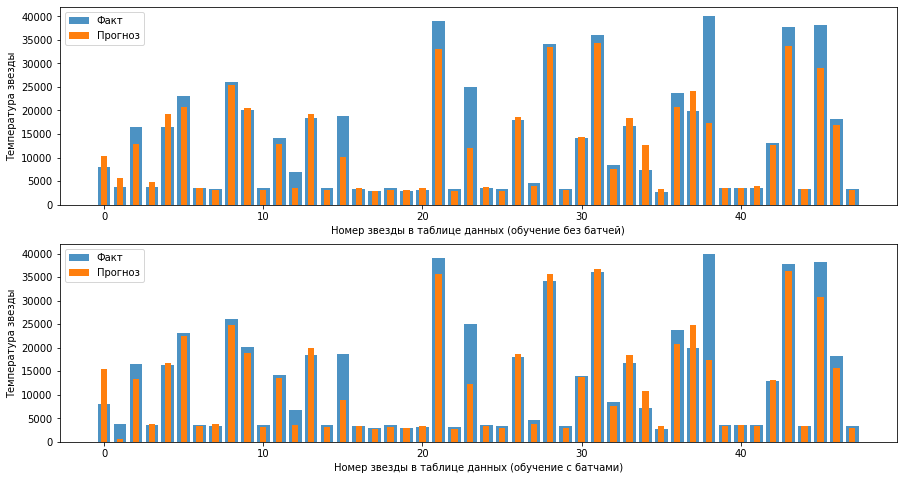

In [265]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

test_pred = net.forward(test_X).detach().numpy().flatten()
test_pred_1 = net_1.forward(test_X).detach().numpy().flatten()
star_index = [i for i in range(len(test_y.numpy()))]

ax[0].bar(x=star_index, height=test_y, alpha=0.8, label='Факт');
ax[0].bar(x=star_index, height=test_pred, alpha=1, label='Прогноз', width=0.4)
ax[0].set_xlabel('Номер звезды в таблице данных (обучение без батчей)')
ax[0].set_ylabel('Температура звезды')
ax[0].legend();

ax[1].bar(x=star_index, height=test_y, alpha=0.8, label='Факт');
ax[1].bar(x=star_index, height=test_pred_1, alpha=1, label='Прогноз', width=0.4)
ax[1].set_xlabel('Номер звезды в таблице данных (обучение с батчами)')
ax[1].set_ylabel('Температура звезды')
ax[1].legend();

Интересно, что график истинных и предсказанных значений у НС, которая обучалась без батчей выглядит как-будто бы чуть точнее, чем у НС, которая обучалась с использование батчей. Хотя ошибка первой модели на тестовых данных незначительно выше, нежели у второй.

**Вывод**  
Наилучшей архитектурой из тех, которые удалось опробовать, оказалась следующая архитектура:  
- Количество скрытых слоев: 4
- Количество нейронов на каждом слое: 100, 50, 25, 10
- Наилучшая итерация: 5000
- Наилучший темп обучения: 0.001
- RMSE на тренировочных данных: 2672.5452
- RMSE на тестовых данных:  4579.9873  

Среди НС, которые обучались по батчам наилучшая архитектура выглядит также. При качество, которое удалось получить в ходе обучения незначительно выше.  
- Размер батча: 35
- Наилучшая итерация: 7300
- RMSE на тренировочных данных: 2558.9136
- RMSE на тестовых данных:   4303.446  

Лучшие результаты показали модели на признаках, к которым не былл применен PCA.

## Улучшение нейронной сети

Создадим решение с перебором параметров нейросети. Список параметров:
- «dropout»
- «размер батча»

In [43]:
# Создадим класс нейронной сети.
class RegressorModule(nn.Module):
    def __init__(self, dropout=0.5):
        super(RegressorModule, self).__init__()
        
        self.dropout = dropout

        self.fc1 = nn.Linear(11, 100)
        self.ac1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(100, 50)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 25)
        self.ac3 = nn.ReLU()
        self.fc4 = nn.Linear(25, 10)
        self.ac4 = nn.ReLU()
        self.fc5 = nn.Linear(10, 1)
        self.ac5 = nn.ReLU()

    def forward(self, X, **kwargs):
        X = self.fc1(X)
        X = self.ac1(X)
        X = self.dropout(X)
        X = self.fc2(X)
        X = self.ac2(X)
        X = self.fc3(X)
        X = self.ac3(X)
        X = self.fc4(X)
        X = self.ac4(X)
        X = self.fc5(X)
        X = self.ac5(X)
        return X
    
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
        nn.init.xavier_normal_(layer.weight)

In [35]:
net_regr = NeuralNetRegressor(module=RegressorModule,
                              optimizer=t.optim.Adam,
                              criterion=nn.MSELoss,
                              max_epochs=7000,
                              lr=1e-3,
                              train_split=False
                             ).initialize()


params = {'module__dropout': [0, 0.5], 
          'batch_size': [30, 50, 80, -1]}

gs = GridSearchCV(net_regr, params, refit=False, cv=3, scoring='neg_root_mean_squared_error', verbose=2)

In [117]:
gs.fit(tens_train_X, tens_train_y.reshape(-1, 1))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
  epoch      train_loss     dur
-------  --------------  ------
      1  155626280.0000  0.0163
      2  155626280.0000  0.0091
      3  155626280.0000  0.0267
      4  155626280.0000  0.0107
      5  155626280.0000  0.0750
      6  155626280.0000  0.0116
      7  155626280.0000  0.0155
      8  155626280.0000  0.0754
      9  155626280.0000  0.0106
     10  155626280.0000  0.0873
     11  155626280.0000  0.0107
     12  155626280.0000  0.0864
     13  155626280.0000  0.0102
     14  155626280.0000  0.0092
     15  155626280.0000  0.0821
     16  155626280.0000  0.0114
     17  155626280.0000  0.0797
     18  155626280.0000  0.0092
     19  155626280.0000  0.0088
     20  155626280.0000  0.0784
     21  155626280.0000  0.0091
     22  155626280.0000  0.0858
     23  155626280.0000  0.0103
     24  155626280.0000  0.0091
     25  155626280.0000  0.0808
     26  155626280.0000  0.0093
     27  155626278.0000  0.0092
     28  155

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (fc1): Linear(in_features=11, out_features=100, bias=True)
    (ac1): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (ac2): ReLU()
    (fc3): Linear(in_features=50, out_features=25, bias=True)
    (ac3): ReLU()
    (fc4): Linear(in_features=25, out_features=10, bias=True)
    (ac4): ReLU()
    (fc5): Linear(in_features=10, out_features=1, bias=True)
    (ac5): ReLU()
  ),
),
             param_grid={'batch_size': [30, 50, 80, -1],
                         'module__dropout': [0, 0.5]},
             refit=False, scoring='neg_root_mean_squared_error', verbose=2)

In [118]:
print(gs.best_score_, gs.best_params_)

-4919.324869791667 {'batch_size': 80, 'module__dropout': 0}


Возьмем все размер батча равный 35, так как именно с ним нам удалось получить наилучшиий результат на тестовой выборке.

In [58]:
best_nn = RegressorModule(dropout=0)

best_nn.apply(init_weights)

batch_fit_net(best_nn, tens_train_X, tens_train_y, tens_test_X, tens_test_y, 
              num_epochs=20000, batch_size=35, show_res_every=100, lr=1e-3, l1_reg=0, l2_reg=0, early_stop=4500)

In [44]:
test_pred = best_nn.forward(tens_test_X).flatten()
rmse_on_test = mean_squared_error(tens_test_y.numpy(), test_pred.detach().numpy(), squared=False)
print(rmse_on_test)

4491.905


Построим график правильных и предсказанных ответов.

RMSE: 4491.905


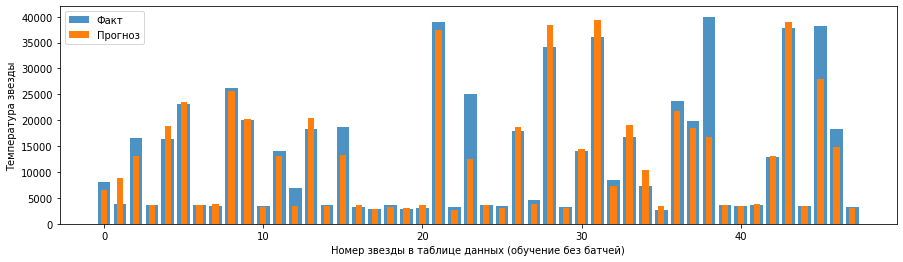

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

star_index = [i for i in range(len(tens_test_y.numpy()))]

ax.bar(x=star_index, height=tens_test_y, alpha=0.8, label='Факт');
ax.bar(x=star_index, height=test_pred.detach().numpy(), alpha=1, label='Прогноз', width=0.4)
ax.set_xlabel('Номер звезды в таблице данных (обучение без батчей)')
ax.set_ylabel('Температура звезды')
ax.legend();
print('RMSE:', rmse_on_test)

**Резюме:**    
Не смотря на то, что при подборе гиперпараметров в качестве наилучшего размера батча было выбрано число 80, ошибка на кросс-валидации (4919 Кельвина), а также на тестовых данных (5800 Кельвинов) оказалась выше, чем при размере батча 35 (ошибка 4303 Кельвина на тесте).  
Для того, чтобы обучить финальную модель, были взяты гиперпараметры модели из первой части проекта, а именно: размер батча равный 35.  
Финальная метрика на тестовых данных. после повторного обучения модели составила 4491.9 Кельвина.

## Выводы

Целью проекта являлось построить модель нейронной сети, способную предсказывать темепературу на поверхности звезды по заданным признакам.  
В ходе проекта были проделаны следующие шаги:
1. Был произведен исследовательский анализ данных, в ходе которого было выявлено, что:  
   - Температура (целевой показатель) имеет корреляцию с Абсолютной звездной величиной (-0.42), Относительной светимостью (0.39) и Цветом звезды
   - Относительная светимость имеет сильную корреляцию с Радиусом (-0.53)
   - Радиус имеет сильную корреляцию с Абсолютной звездной величиной (-0.61)  
   
   На основании анализа, было принято решение исключить признак `Star_type` из обучения, так как он может быть излишним и его наличие может привести к утечке данных.  
   Также, была произведена предобработка данных, в ходе которой признак `Star_color` был очищен от неявных дубликатов и редко встречающихся значений.  
   
   
2. Была произведена подготовка данных к обучению модели. На этом этапе мы:
   - Разделили выборку на тренировочную и тестовую
   - Преобразовали категогриальные признаки методом one-hot encoding
   - Отмасштабировали количественные признаки
   - Создали еще один набор обучающих признаков, к которму применили метод PCA для уменьшения размерности.
   
   
3. Были построены и опробованы несколько архитектур нейронной сети, которые отличались количеством скрытых слоев (от 2-х до 5-и), количеством нейроннов в каждом слое, коэффициентом и типом реуляризации, а также размером батча и темпом градиентного спуска при обучении:  
   Наилучшей архитектурой из тех, которые удалось опробовать, оказалась следующая:  
    - Количество скрытых слоев: 4
    - Количество нейронов на каждом слое: 100, 50, 25, 10
    - Наилучшая итерация: 5000
    - Наилучший темп обучения: 0.001
    - RMSE на тренировочных данных: 2672.5452
    - RMSE на тестовых данных:  4579.9873    
    
   Среди НС, которые обучались по батчам наилучшая архитектура выглядит также. При этом качество, которое удалось получить в ходе обучения оказалось незначительно выше.  
    - Размер батча: 35
    - Наилучшая итерация: 7300
    - RMSE на тренировочных данных: 2558.9136
    - RMSE на тестовых данных:   4303.446  

    Лучшие результаты показали модели на признаках, к которым не был применен PCA.  
    

4. Следующим шагом был произведен перебор гиперпараметров для той архитектуры нейронной сети, которая была выбрана на предыдущем шаге (4 скрытых слоя: 100, 50, 25, 10 нейронов в каждом). Перебор гиперпараметров касался размера dropout (0, 0.5) и размера батча (30, 50, 80, весь датасет)
   - По результатам перебора, наилучшим сочетанием гиперпараметров оказалось: размер батча=80, dropout=0.
   
   Однако, качество, которое было получено с подобранными гиперпараметрами на кросс-валидации (ошибка 4919 Кельвинов) и качество, которое было получено на тестовых данных (ошибка 5800 Кельвинов) уступало тому качеству, которое было получено на тестовых данных нейросетью, построенной в первой части проекта (ошибка 4303 Кельвина). В результате чего, было принято решение взять гиперпараметры нейросети, из первой части проекта.  
  
  После того, как модель была вновь обучена и проверена на тестовых данных, была получена ошибка 4491,9 Кельвина.

**Резюме:**  
Достаточно сложно делать какие-либо выводы, так как в данном проекте мы обладали невероятно малым количеством данных, в то время как для решения задачи требовалось использование нейросетей. Мы не могли себе позволить отделить валидационную выборку, из-за чего качество при обучении приходилось выводить сразу на тестовой.  
Однако, что точно можно выделить, так это то, что благодаря делению выборки на батчи, удалось получить ошибку на тестовых данных менее 4500 Кельвина. При прочих равных гиперпараметрах, обучение без батчей, как правило, показывало незначительно худший результат.